In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [9]:
# Число деревьев в ансамбле
n_trees = [i for i in range(1,51)]

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

train_err_list = []
test_err_list = []

for n_tree in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_err_list.append(train_errors)
    test_err_list.append(test_errors)

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа деревьев

In [10]:
def get_tree_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Tree number')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

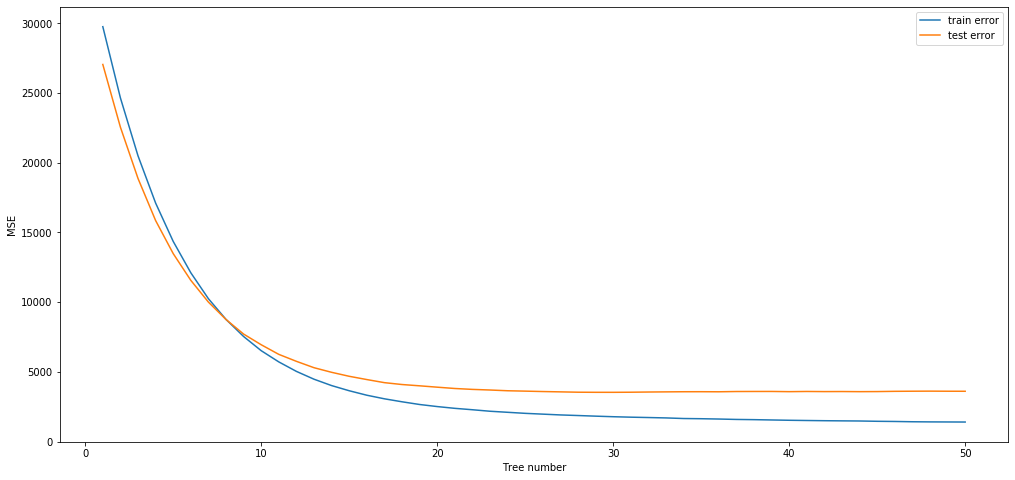

In [11]:
plt.figure(figsize=(17,8))
get_tree_error_plot(n_trees, train_err_list[-1], test_err_list[-1])

Как мы видим с ростом числа деревьев ошибка снижается. Причем до 6-7 деревьев снижение кардинальное. Далее график начинает сглаживаться и примерно с 8 деревьев графики расходятся. График трейна продолжает снижение. График же теста все сильнее стремится к параллельности с осью x

In [12]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_tree

# Максимальная глубина деревьев
max_depths = [i for i in range(1,15)]

# Шаг
eta = 0.1

train_err_depth_list = []
test_err_depth_list = []

for max_depth in max_depths:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_err_depth_list.append(train_errors[-1])
    test_err_depth_list.append(test_errors[-1])

In [13]:
def get_depth_error_plot(max_depths, train_err, test_err):
    plt.xlabel('Depth number')
    plt.ylabel('MSE')
    plt.plot(max_depths, train_err, label='train error')
    plt.plot(max_depths, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

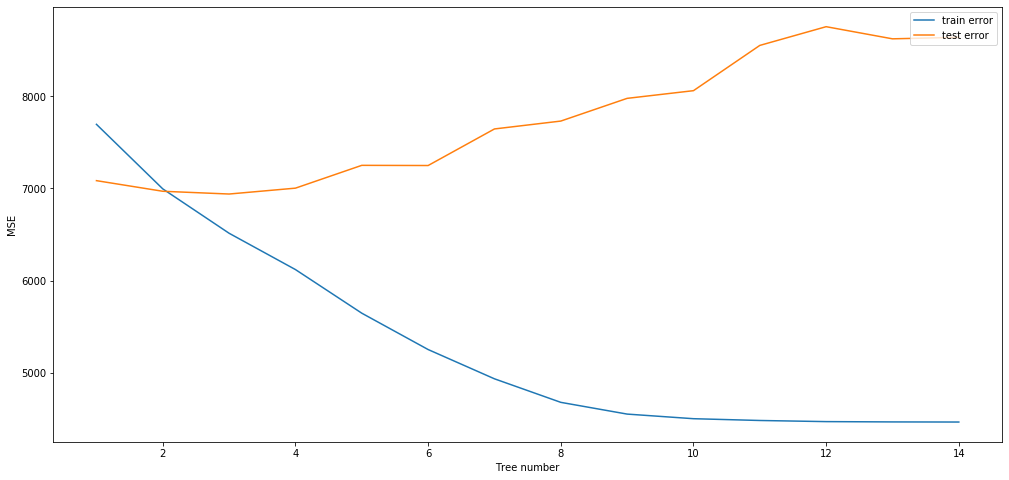

In [14]:
plt.figure(figsize=(17,8))
get_tree_error_plot(max_depths, train_err_depth_list, test_err_depth_list)

С ростом глубины дерева ошибка на трейне снижается, а вот на тесте после 3 начинает расти, что говорит о переобучении модели

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [15]:
def st_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, part_size):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # Сгенерируем индексы для подвыборки
            indexes = np.random.randint(0, high = len(X_train), size = int(len(X_train) * part_size))
            
            # Получим случайную подвыборку
            X_train_part = np.array([X_train[i] for i in indexes])
            y_train_part = np.array([y_train[i] for i in indexes])
            target_part = np.array([target[i] for i in indexes])
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_part, bias(y_train_part, target_part))
            
            train_errors.append(mean_squared_error(y_train_part, gb_predict(X_train_part, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [16]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

# Доля выборки
part_size = 0.5

trees, st_train_errors, st_test_errors = st_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, part_size)

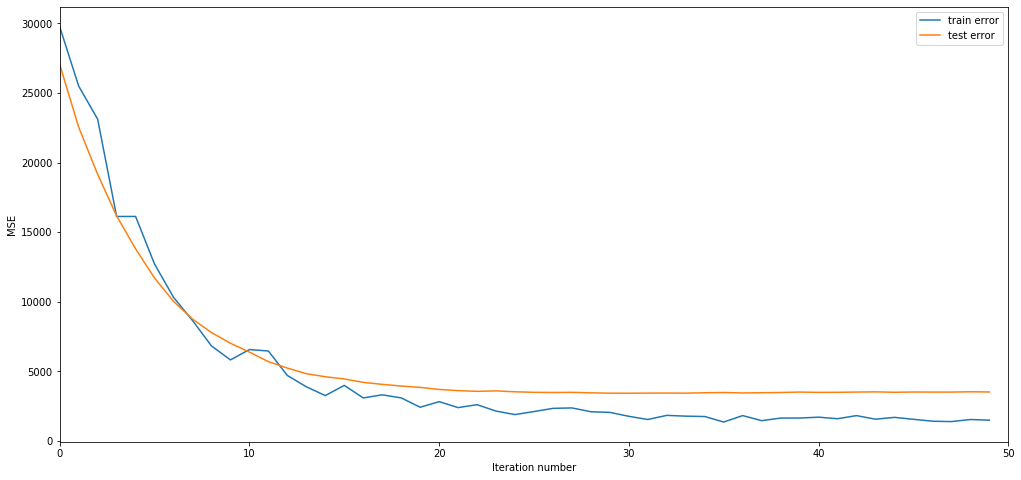

In [17]:
plt.figure(figsize=(17,8))
get_error_plot(n_trees, st_train_errors, st_test_errors)

График теста в целом похож на градиентный бустинг. А вот график трейна ломаный. Видимо это связано с тем, насколько разнообразную часть сета мы захватили для обучения